In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

import gym
from acrobot import AcrobotEnv

In [2]:
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

In [3]:
import warnings 
warnings.filterwarnings('ignore')

## Explore The Environment

In [4]:
env = AcrobotEnv(); env.seed(90);

Environment Display:
State space Box(6,)
Action space Discrete(3)
Final score: -200.0


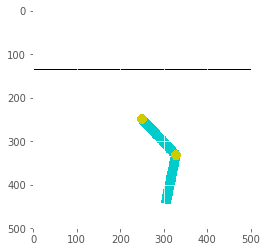

In [5]:
print('Environment Display:')

state = env.reset() # reset environment to a new, random state
score = 0

num_episodes = 200 # limit of moves in this environment
for time_step in range(num_episodes):
    
    action = env.action_space.sample()
    env.render()
    next_state, reward, done, _ = env.step(action) # a -1 reward is applied for each move taken (including doing nothing)
    score += reward
    
    state = next_state
    if done:
        break

print('State space', env.observation_space)
print('Action space', env.action_space)
print('Final score:', score)
plt.imshow(env.render(mode='rgb_array'))
plt.show()

env.close()

In [6]:
# explore state (observation) space
space_low = env.observation_space.low
space_high = env.observation_space.high
print("State space:", env.observation_space)
print(f"- low: {space_low[0]}, {space_low[1]}, {space_low[2]}, {space_low[3]}, {space_low[4]}, {space_low[5]}")
print(f"- high: {space_high[0]}, {space_high[1]}, {space_high[2]}, {space_high[3]}, {space_high[4]}, {space_high[5]},", )

State space: Box(6,)
- low: -1.0, -1.0, -1.0, -1.0, -12.566370964050293, -28.274333953857422
- high: 1.0, 1.0, 1.0, 1.0, 12.566370964050293, 28.274333953857422,


In [7]:
# explore the action space
print("Action space:", env.action_space)

Action space: Discrete(3)


## Discretize the State Space with a Tiling Grid

In [8]:
def create_tiling_grid(low, high, bins=(10, 10), offsets=(0.0, 0.0)):
    """Define a uniformly-spaced grid that can be used for tile-coding a space."""
    
    grid = [np.linspace(low[dim], high[dim], bins[dim] + 1)[1:-1] + offsets[dim] for dim in range(len(bins))]
    return grid

In [9]:
def create_tilings(low, high, tiling_specs):
    """Define multiple tilings using the provided specifications."""
    
    return [create_tiling_grid(low, high, bins, offsets) for bins, offsets in tiling_specs]

In [10]:
def visualize_tilings(tilings):
    """Plot each tiling as a grid."""
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    linestyles = ['-', '--', ':']
    legend_lines = []
    
    fig, ax = plt.subplots(figsize=(10, 10))
    for i, grid in enumerate(tilings):
        for x in grid[0]:
            l = ax.axvline(x=x, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], label=i)
        for y in grid[1]:
            l = ax.axhline(y=y, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)])
        legend_lines.append(l)
    ax.grid('off')
    ax.legend(legend_lines, ["Tiling #{}".format(t) for t in range(len(legend_lines))], facecolor='white', framealpha=0.9)
    ax.set_title("Tilings")
    
    return ax

In [11]:
low = [-1.0, -5.0]
high = [1.0, 5.0]

In [12]:
tiling_specs = [((10, 10), (-0.066, -0.33)), ((10, 10), (0.0, 0.0)), ((10, 10), (0.066, 0.33))]
tilings = create_tilings(low, high, tiling_specs) # tiling specs: [(bins, offsets)]

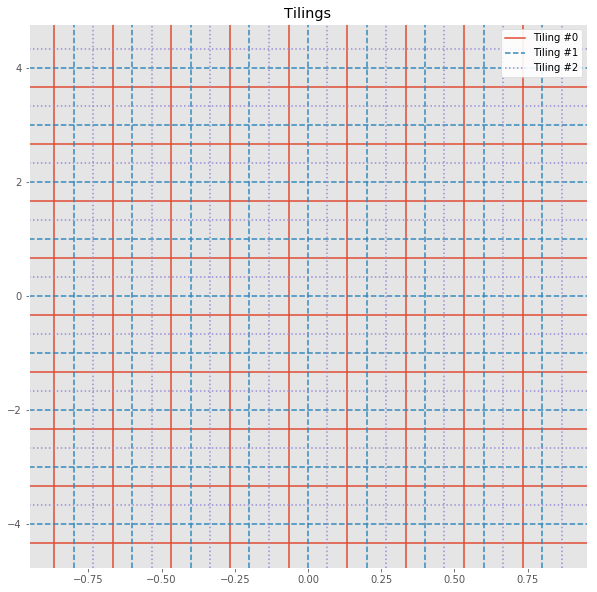

In [13]:
ax = visualize_tilings(tilings); plt.show()

In [14]:
def discretize(sample, grid):
    """Discretize a sample as per given grid."""
    
    return tuple(int(np.digitize(s, g)) for s, g in zip(sample, grid))

In [15]:
def tile_encode(sample, tilings, flatten=False):
    """Encode given sample using tile-coding."""
    
    encoded_sample = [discretize(sample, grid) for grid in tilings]
    return np.concatenate(encoded_sample) if flatten else encoded_sample

In [16]:
state_samples = [(-1.2 , -5.1 ), (-0.75,  3.25), (-0.5 ,  0.0 ), ( 0.25, -1.9 ), 
                 ( 0.15, -1.75), ( 0.75,  2.5 ), ( 0.7 , -3.7 ), ( 1.0 ,  5.0 )]

encoded_samples = [tile_encode(sample, tilings) for sample in state_samples]

## Visualize The Encoding

In [17]:
def visualize_encoded_samples(samples, encoded_samples, tilings, low=None, high=None):
    """Visualize samples by activating the respective tiles."""
    
    samples = np.array(samples)
    
    # show tiling grids
    ax = visualize_tilings(tilings)
    
    # if bounds (low, high) are specifid, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # pre-render (invisible) samples to automatically set reasonable axis limits, and use them as (low, high)
        ax.plot(samples[:, 0], samples[:, 1], 'o', alpha=0.0)
        low = [ax.get_xlim()[0], ax.get_ylim()[0]]
        high = [ax.get_xlim()[1], ax.get_ylim()[1]]
    
    # map each encoded sample (which is really a list of indices) to the corresponding tiles it belongs to
    tilings_extended = [np.hstack((np.array([low]).T, grid, np.array([high]).T)) for grid in tilings]  # add low and high ends
    tile_centers = [(grid_extended[:, 1:] + grid_extended[:, :-1]) / 2 for grid_extended in tilings_extended]  # compute center of each tile
    tile_toplefts = [grid_extended[:, :-1] for grid_extended in tilings_extended]  # compute topleft of each tile
    tile_bottomrights = [grid_extended[:, 1:] for grid_extended in tilings_extended]  # compute bottomright of each tile

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    for sample, encoded_sample in zip(samples, encoded_samples):
        for i, tile in enumerate(encoded_sample):
            # shade the entire tile with a rectangle
            topleft = tile_toplefts[i][0][tile[0]], tile_toplefts[i][1][tile[1]]
            bottomright = tile_bottomrights[i][0][tile[0]], tile_bottomrights[i][1][tile[1]]
            ax.add_patch(Rectangle(topleft, bottomright[0] - topleft[0], bottomright[1] - topleft[1],
                                   color=colors[i], alpha=0.33))

            # in case sample is outside tile bounds, it may not have been highlighted properly
            if any(sample < topleft) or any(sample > bottomright):
                # so plot a point in the center of the tile and draw a connecting line
                cx, cy = tile_centers[i][0][tile[0]], tile_centers[i][1][tile[1]]
                ax.add_line(Line2D([sample[0], cx], [sample[1], cy], color=colors[i]))
                ax.plot(cx, cy, 's', color=colors[i])
                
    # finally, plot original samples
    ax.plot(samples[:, 0], samples[:, 1], 'o', color='r')
    ax.margins(x=0, y=0) # remove unnecessary margins
    ax.set_title("Tile-encoded samples")
    
    return ax

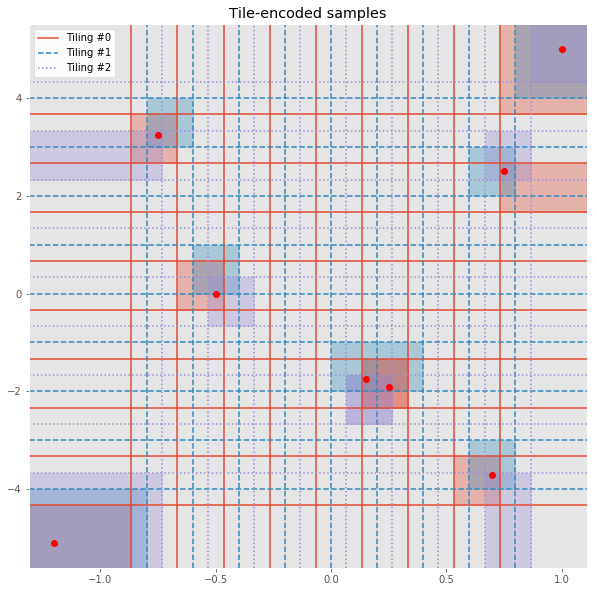

In [18]:
ax = visualize_encoded_samples(state_samples, encoded_samples, tilings); plt.show()

## Define Tiled Q-table

In [19]:
class QTable:
    """Simple Q-table."""
    
    def __init__(self, state_size, action_size):
        """Initialize Q-table."""
        
        self.state_size = state_size
        self.action_size = action_size
        
        # create Q_table, initialize all Q values to zero
        self.Q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        # print('Q_table(): size =', self.Q_table.shape)

In [20]:
class TiledQTable:
    """Composite Q-table with an internal tile coding scheme."""
    
    def __init__(self, low, high, tiling_specs, action_size):
        """Create tilings and initialize internal Q-table(s)."""
        
        self.tilings = create_tilings(low, high, tiling_specs)
        self.state_sizes = [tuple(len(splits)+1 for splits in tiling_grid) for tiling_grid in self.tilings]
        self.action_size = action_size
        self.Q_tables = [QTable(state_size, self.action_size) for state_size in self.state_sizes]
        print('TiledQTable(): no. of internal tables =', len(self.Q_tables))
        
    def get(self, state, action):
        """Get Q-value for given <state, action> pair."""
        
        # encode state to get tile indices
        encoded_state = tile_encode(state, self.tilings)
        
        # retrieve q-value for each tiling, and return their average
        value = 0.0
        for idx, Q_table in zip(encoded_state, self.Q_tables):
            value += Q_table.Q_table[tuple(idx + (action,))]
        value /= len(self.Q_tables)
        return value
    
    def update(self, state, action, value, alpha=0.1):
        """Soft-update Q-value for given <state, action> pair to value."""
        
        # encode state to get tile indices
        encoded_state = tile_encode(state, self.tilings)
        
        # update Q-value for each tiling by update factor alpha
        for idx, Q_table in zip(encoded_state, self.Q_tables):
            value_ = Q_table.Q_table[tuple(idx + (action,))] # current value
            Q_table.Q_table[tuple(idx + (action,))] = alpha * value + (1.0 - alpha) * value_

In [21]:
tiledQ = TiledQTable(low, high, tiling_specs, 2)

TiledQTable(): no. of internal tables = 3


## Define Q-Learning Agent

In [22]:
class QLearningAgent:
    """Q-Learning agent that can act on a continuous state space by discretizing it."""

    def __init__(self, env, tiledQ, alpha=0.02, gamma=0.99, 
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=.01, seed=90):
        """Initialize variables, create grid for discretization."""
        
        # environment info
        self.env = env
        self.tiledQ = tiledQ
        self.state_sizes = tiledQ.state_sizes # list of state sizes for each tiling
        self.action_size = self.env.action_space.n # 1-dimensional discrete action space
        self.seed = np.random.seed(seed)
        
        print('Environment:', self.env)
        print('State space size:', self.state_sizes)
        print('Action space size:', self.action_size)
        
        # learning parameters
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount factor
        self.epsilon = self.initial_epsilon = epsilon # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate # how quickly should we decrease epsilon
        self.min_epsilon = min_epsilon
        
    def reset_episode(self, state):
        """Reset variables for a new episode."""
        
        # gradually decrease exploration rate
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)
        
        self.last_state = state
        Q_s = [self.tiledQ.get(state, action) for action in range(self.action_size)]
        self.last_action = np.argmax(Q_s)
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon
        
    def act(self, state, reward=None, done=None, mode='train'):
        """Pick next action and update internal Q table (when mode != 'test')."""
        
        Q_s = [self.tiledQ.get(state, action) for action in range(self.action_size)]
        
        if mode == 'test':
            # test mode: pick the best action from Q-table
            action = np.argmax(Q_s)
        else:
            # train mode (default): Update Q-table, pick the next action
            # note: we update the Q-table entry for the last (state, action) pair with current state, reward
            value = reward + self.gamma * max(Q_s)
            self.tiledQ.update(self.last_state, self.last_action, value, self.alpha)
            
            # exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # pick the best action from Q-table
                action = np.argmax(Q_s)
                
        # roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action

In [23]:
n_bins = 5
bins = tuple([n_bins]*env.observation_space.shape[0])
offset_position = (space_high - space_low) / (3*n_bins)

tiling_specs = [(bins, -offset_position), (bins, tuple([0.0]*env.observation_space.shape[0])), (bins, offset_position)]
tiledQ = TiledQTable(space_low, space_high, tiling_specs, env.action_space.n)

TiledQTable(): no. of internal tables = 3


In [24]:
Q_agent = QLearningAgent(env, tiledQ)

Environment: <AcrobotEnv instance>
State space size: [(5, 5, 5, 5, 5, 5), (5, 5, 5, 5, 5, 5), (5, 5, 5, 5, 5, 5)]
Action space size: 3


## Train The Agent

In [25]:
def run(agent, env, num_episodes=10000, mode='train'):
    """Run agent in given reinforcement learning environment and return scores."""
    
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, num_episodes+1):
        
        # initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False
        
        # roll out steps until done
        while not done:
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            action = agent.act(next_state, reward, done, mode)
            
            state = next_state
        
        # save final score
        scores.append(total_reward)
        
        # print episode status
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score
                    
            if i_episode % 1 == 0:
                print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score), end="")
                sys.stdout.flush()
    return scores

In [26]:
scores = run(Q_agent, env)

Episode 10000/10000 | Max Average Score: -253.04

## Evaluate The Agent

In [27]:
def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    
    # filter out very low scores obtained
    scores = [score for score in scores if score > np.mean(scores)]
    
    plt.figure(figsize=(10, 5))
    
    plt.plot(scores)
    plt.title('Scores')
    plt.xlabel('Number of episodes')
    plt.ylabel('Total of collected rewards')
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean)
    
    plt.show()
    return rolling_mean

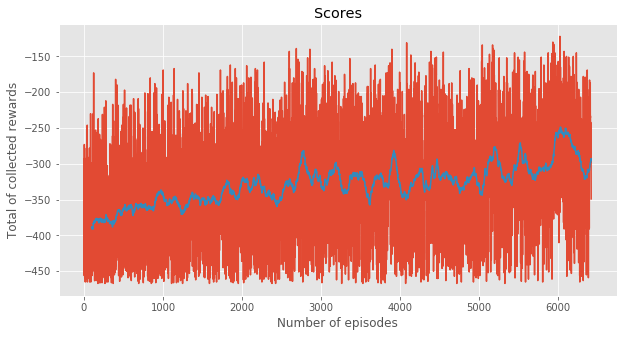

In [28]:
rolling_mean = plot_scores(scores)

## Test The Agent

In [29]:
# run in test mode and analyze scores obtained
test_scores = run(Q_agent, env, num_episodes=100, mode='test')

[TEST] Completed 100 episodes with avg. score = -269.2


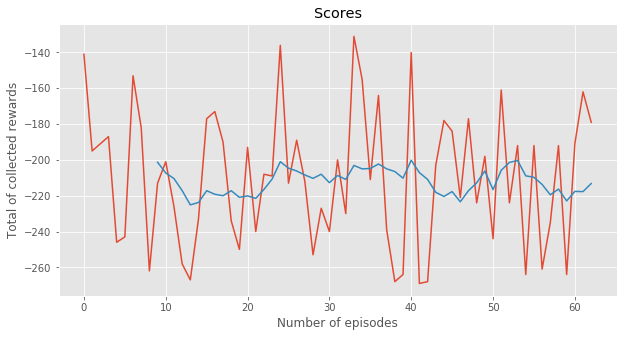

In [30]:
print(f'[TEST] Completed {len(test_scores)} episodes with avg. score = {np.mean(test_scores)}')
rolling_mean = plot_scores(test_scores, rolling_window=10)

## Watch The Agent

In [76]:
print('Environment Display:')
state = env.reset() # reset environment to a new, random state
score = 0

num_episodes = 200
for time_step in range(num_episodes):
    
    action = Q_agent.act(state, mode='test')
    env.render()
    next_state, reward, done, _ = env.step(action)
    score += reward
    
    state = next_state
    if done:
        break
        
print('Final score:', score)
env.close()

Environment Display:
Final score: -262.0


---